# **Downloading Dataset**

In [ ]:
#!/bin/bash
!kaggle datasets download emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 98% 644M/658M [00:03<00:00, 182MB/s]
100% 658M/658M [00:03<00:00, 202MB/s]


In [ ]:
!unzip plantdisease.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74

In [ ]:
!pip install keras.utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2632 sha256=fc2c1cd09c4bb4522b4e787a41cb8965e7f22716a13b6327e7e73b986fcbf3b9
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils


# Importing Needed Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,
    AveragePooling2D, GlobalAveragePooling2D, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121

In [ ]:
# import tensorflow as tf


# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

# Data Preprocessing

In [ ]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = '/content/plantvillage/PlantVillage'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
20634,Tomato_healthy/9e2a71e5-2a59-4e62-9c6c-581fe90...,14,Tomato_healthy
20635,Tomato_healthy/de914baa-f72d-4cbf-a9fd-a60baf4...,14,Tomato_healthy
20636,Tomato_healthy/3e2fa71c-73a6-48f5-9175-4d43a07...,14,Tomato_healthy
20637,Tomato_healthy/45167988-3f78-4309-8ce2-633d752...,14,Tomato_healthy
20638,Tomato_healthy/10126910-47a0-4b22-b3ee-ce9eb4d...,14,Tomato_healthy


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato_healthy/e47d2178-aaf3-438b-bcce-2fcb6ef...,14,Tomato_healthy
1,Potato___Early_blight/c10f959b-1f3d-4581-8299-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot/2cbfb4e3-8327-470f-9...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/bb8861fc-350e-49da-86aa-1b475a2...,14,Tomato_healthy
4,Tomato_Leaf_Mold/be2680f9-cdba-44e5-8834-7bc5b...,8,Tomato_Leaf_Mold


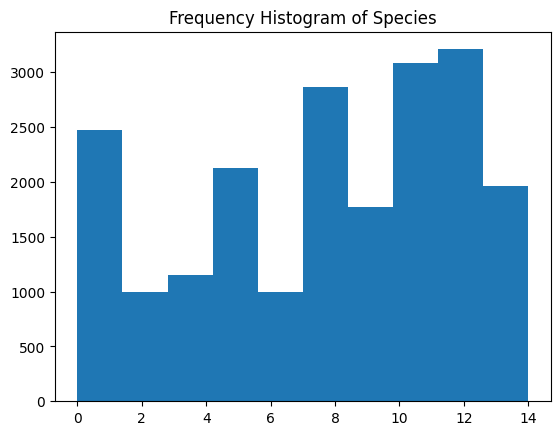

<Figure size 1200x1200 with 0 Axes>

In [ ]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

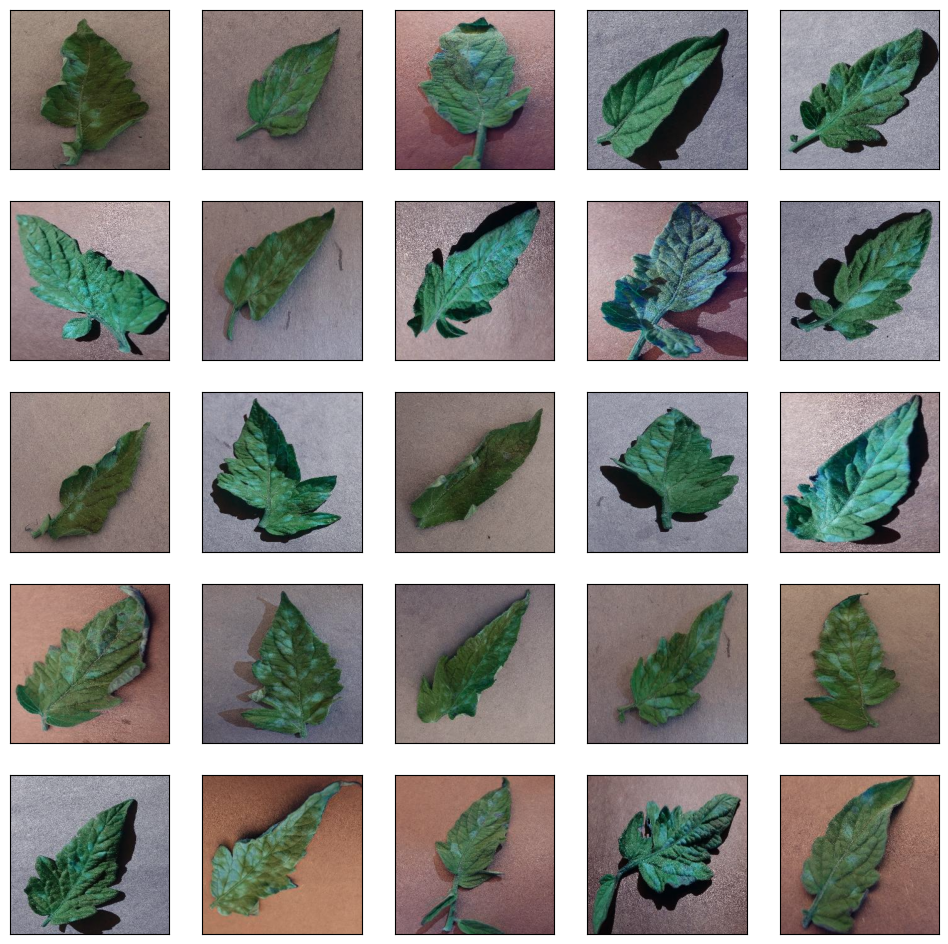

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Leaf_Mold', 5, 5)

In [ ]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

20639it [00:27, 750.49it/s] 


Train Shape: (20639, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

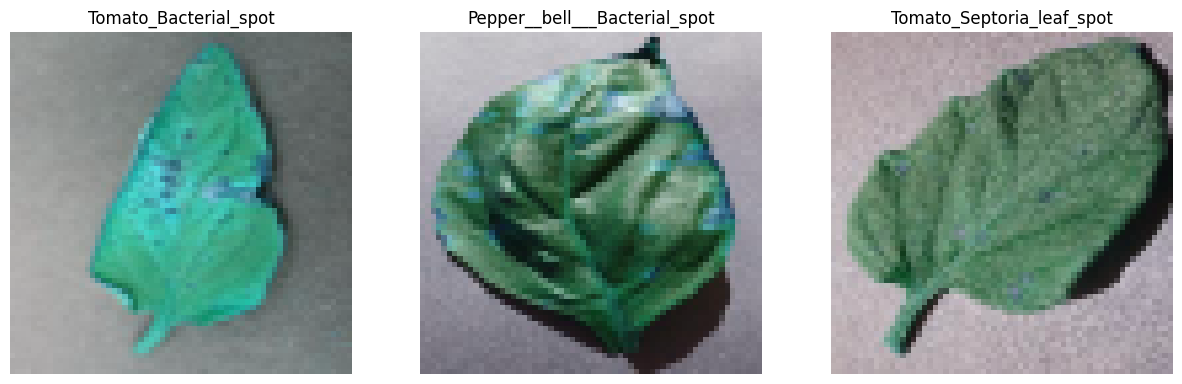

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 20
SIZE=64
N_ch=3

# Model 1 DenseNet121
* Accuracy : 90.8%

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam

def build_efficient_densenet(input_shape=(64, 64, 3), num_classes=15):
    # Load DenseNet121 with pre-trained ImageNet weights, excluding the top layer
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Input layer
    input = Input(shape=input_shape)

    # Optional Conv2D layer to ensure input compatibility
    x = Conv2D(3, (3, 3), padding='same', activation='relu')(input)

    # DenseNet feature extractor
    x = densenet_base(x)

    # Global average pooling to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)

    # Add batch normalization for faster convergence
    x = BatchNormalization()(x)

    # Add dropout for regularization to prevent overfitting
    x = Dropout(0.5)(x)

    # Fully connected layer with higher capacity
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax activation for classification
    output = Dense(num_classes, activation='softmax', name='output')(x)

    # Define the model
    model = Model(inputs=input, outputs=output)

    # Compile the model with an efficient optimizer
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Model summary
    model.summary()

    return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the generator to the training data
datagen.fit(X_train)



# Callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('model_DN.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Build the model
model = build_efficient_densenet(input_shape=(64, 64, 3), num_classes=15)

# Train the model
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=20,
    validation_data=(X_val, Y_val),
    callbacks=[annealer, checkpoint],
    verbose=2
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 3)           │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 2, 2, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,308,963 (27.88 MB)

 Trainable params: 7,222,755 (27.55 MB)

 Non-trainable params: 86,208 (336.75 KB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.09254, saving model to model_DN.keras
257/257 - 274s - 1s/step - accuracy: 0.5543 - loss: 1.4825 - val_accuracy: 0.0925 - val_loss: 6.4993 - learning_rate: 0.0010
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.09254
257/257 - 2s - 8ms/step - accuracy: 0.7031 - loss: 1.2000 - val_accuracy: 0.0809 - val_loss: 7.6891 - learning_rate: 0.0010
Epoch 3/20

Epoch 3: val_accuracy improved from 0.09254 to 0.71609, saving model to model_DN.keras
257/257 - 37s - 144ms/step - accuracy: 0.7795 - loss: 0.6921 - val_accuracy: 0.7161 - val_loss: 0.8136 - learning_rate: 0.0010
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.71609
257/257 - 2s - 7ms/step - accuracy: 0.8125 - loss: 0.6225 - val_accuracy: 0.6962 - val_loss: 0.9013 - learning_rate: 0.0010
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.71609
257/257 - 37s - 145ms/step - accuracy: 0.8395 - loss: 0.4869 - val_accuracy: 0.6945 - val_loss: 1.5823 - learning_rate: 0.0010
Epoch 6/20

Epoch 6: val_accuracy did not improve from 0.71609
257/257 - 2s - 7ms/step - accuracy: 0.9219 - loss: 0.2851 - val_accuracy: 0.6834 - val_loss: 1.6351 - learning_rate: 0.0010
Epoch 7/20

Epoch 7: val_accuracy 

In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9089 - loss: 0.3295
Validation Loss: 0.311128705739975
Validation Accuracy: 0.9086724519729614


# Model 2: MobileNetV2


*   Acc: [64~67]%
*   Probably not going to be used



In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_mobilenetv2(input_shape=(SIZE, SIZE, N_ch), num_classes=15):
    # Load MobileNetV2 with pre-trained ImageNet weights, excluding the top layer
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global average pooling
    x = Dropout(0.5)(x)  # Add dropout for regularization
    x = Dense(128, activation='relu')(x)  # Fully connected layer
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base_model layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    return model

In [ ]:
# Build MobileNetV2
model_MNV2 = build_mobilenetv2(input_shape=(SIZE, SIZE, N_ch), num_classes=15)

# Compile the model
model_MNV2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_MNV2.summary()

<ipython-input-26-b40b0b10ff8b>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 32, 32, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 32, 32, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 32, 32, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 32, 32, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 32, 32, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 32, 32, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 32, 32, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 32, 32, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 32, 32, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 32, 32, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 32, 32, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 33, 33, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 16, 16, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
 #Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the generator on the training data
datagen.fit(X_train)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Callbacks for training
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('model_MNV2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
# Ensure steps_per_epoch is calculated correctly
steps_per_epoch = len(X_train) // BATCH_SIZE

# Train the model
history = model_MNV2.fit(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    callbacks=[annealer, checkpoint],
    verbose=2
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.62597, saving model to model_MNV2.keras
257/257 - 26s - 99ms/step - accuracy: 0.5379 - loss: 1.4080 - val_accuracy: 0.6260 - val_loss: 1.1369 - learning_rate: 0.0010
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.62597
257/257 - 1s - 5ms/step - accuracy: 0.5625 - loss: 1.3848 - val_accuracy: 0.6238 - val_loss: 1.1398 - learning_rate: 0.0010
Epoch 3/20

Epoch 3: val_accuracy improved from 0.62597 to 0.63227, saving model to model_MNV2.keras
257/257 - 24s - 95ms/step - accuracy: 0.5598 - loss: 1.3451 - val_accuracy: 0.6323 - val_loss: 1.1096 - learning_rate: 0.0010
Epoch 4/20

Epoch 4: val_accuracy improved from 0.63227 to 0.63348, saving model to model_MNV2.keras
257/257 - 1s - 5ms/step - accuracy: 0.5312 - loss: 1.4155 - val_accuracy: 0.6335 - val_loss: 1.1094 - learning_rate: 0.0010
Epoch 5/20

Epoch 5: val_accuracy improved from 0.63348 to 0.65964, saving model to model_MNV2.keras
257/257 - 39s - 152ms/step - accuracy: 0.5613 - loss: 1.3340 - val_accuracy: 0.6596 - val_loss: 1.0369 - learning_rate: 0.0010
Epoch 6/20

Epoch 6: val_accuracy did not improve from 0.65964
257/257 - 1s - 3ms/step - accuracy: 0.5156 - loss: 1.2815 - val_accuracy: 0.6582 

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model_MNV2.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6608 - loss: 1.0148
Validation Loss: 0.9820047616958618
Validation Accuracy: 0.6715116500854492


# Vision Transformer (ViT)

In [ ]:
!pip install transformers

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

In [ ]:
from transformers import ViTFeatureExtractor

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Resize images to 224x224 and normalize pixel values
def preprocess_images(images):
    images = np.array([cv2.resize(image, (224, 224)) for image in images])
    inputs = feature_extractor(images=list(images), return_tensors="tf")
    return inputs

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Preprocess X_train and X_val
X_train_processed = preprocess_images(X_train)
X_val_processed = preprocess_images(X_val)

# Keep labels as one-hot encoded
Y_train = to_categorical(Y_train, num_classes=15)
Y_val = to_categorical(Y_val, num_classes=15)

In [ ]:
from transformers import ViTForImageClassification

# Load the ViT model
model_ViT= ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=15  # Number of classes in your dataset
)

# Compile the model
model_ViT.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

#Our Custom CNN

*   Acc: 92.7%


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_custom_cnn(input_shape=(64, 64, 3), num_classes=15):
    model = Sequential()

    # Convolutional Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Block 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Block 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    return model

In [ ]:
model_CNN = build_custom_cnn(input_shape=(64, 64, 3), num_classes=15)

# Compile the model
model_CNN.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model_CNN.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 686,031 (2.62 MB)

 Trainable params: 685,583 (2.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
datagen.fit(X_train)

# Callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('model_CNN_GPU_.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model

history = model_CNN.fit(
        datagen.flow(X_train, Y_train, batch_size=64),
        steps_per_epoch=len(X_train) // 64,
        epochs=30,
        validation_data=(X_val, Y_val),
        callbacks=[annealer, checkpoint],
        verbose=2
    )

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.74855, saving model to model_CNN_GPU_.keras
257/257 - 25s - 97ms/step - accuracy: 0.8850 - loss: 0.3568 - val_accuracy: 0.7485 - val_loss: 1.5907 - learning_rate: 5.0000e-04
Epoch 2/30

Epoch 2: val_accuracy improved from 0.74855 to 0.75872, saving model to model_CNN_GPU_.keras
257/257 - 1s - 3ms/step - accuracy: 0.9375 - loss: 0.2211 - val_accuracy: 0.7587 - val_loss: 1.4476 - learning_rate: 5.0000e-04
Epoch 3/30

Epoch 3: val_accuracy improved from 0.75872 to 0.90746, saving model to model_CNN_GPU_.keras
257/257 - 41s - 161ms/step - accuracy: 0.8881 - loss: 0.3417 - val_accuracy: 0.9075 - val_loss: 0.2854 - learning_rate: 5.0000e-04
Epoch 4/30

Epoch 4: val_accuracy improved from 0.90746 to 0.91328, saving model to model_CNN_GPU_.keras
257/257 - 1s - 3ms/step - accuracy: 0.8906 - loss: 0.2796 - val_accuracy: 0.9133 - val_loss: 0.2744 - learning_rate: 5.0000e-04
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.91328
257

# ResNet50


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_resnet50(input_shape=(64, 64, 3), num_classes=15):
    # Load ResNet50 base model with pre-trained ImageNet weights
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Input layer
    input = Input(shape=input_shape)

    # Use ResNet50 as a feature extractor
    x = resnet_base(input)

    # Global Average Pooling layer to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)

    # Add Batch Normalization to stabilize learning
    x = BatchNormalization()(x)

    # Add a Dropout layer for regularization
    x = Dropout(0.5)(x)

    # Fully connected layer
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax activation for classification
    output = Dense(num_classes, activation='softmax', name='output')(x)

    # Define the model
    model = Model(inputs=input, outputs=output)

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    # Model summary
    model.summary()

    return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the generator on the training data
datagen.fit(X_train)

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Callbacks for training
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('resnet50_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Build ResNet50
model = build_resnet50(input_shape=(64, 64, 3), num_classes=15)

# Train the model
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    validation_data=(X_val, Y_val),
    epochs=15,
    callbacks=[annealer, checkpoint],
    verbose=2
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,654,735 (94.05 MB)

 Trainable params: 24,596,495 (93.83 MB)

 Non-trainable params: 58,240 (227.50 KB)

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.09181, saving model to resnet50_model.keras
257/257 - 117s - 456ms/step - accuracy: 0.6238 - loss: 1.3927 - val_accuracy: 0.0918 - val_loss: 4.2007 - learning_rate: 0.0010
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.09181
257/257 - 2s - 7ms/step - accuracy: 0.7500 - loss: 1.0197 - val_accuracy: 0.0918 - val_loss: 4.0848 - learning_rate: 0.0010
Epoch 3/15

Epoch 3: val_accuracy improved from 0.09181 to 0.09932, saving model to resnet50_model.keras
257/257 - 102s - 398ms/step - accuracy: 0.7664 - loss: 0.7900 - val_accuracy: 0.0993 - val_loss: 4.5647 - learning_rate: 0.0010
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.09932
257/257 - 3s - 10ms/step - accuracy: 0.7812 - loss: 0.5101 - val_accuracy: 0.0969 - val_loss: 4.7370 - learning_rate: 0.0010
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.09932
257/257 - 33s - 129ms/step - accuracy: 0.8135 - loss: 0.6248 - val_accuracy: 0.0870 - val_loss: 6.5

In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7836 - loss: 0.7389
Validation Loss: 0.791495144367218
Validation Accuracy: 0.7710756063461304


#Visulaizuing

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9595 - loss: 0.1311
Validation Loss: 0.13228924572467804
Validation Accuracy: 0.957848846912384
Training history file not found. Unable to plot training metrics.


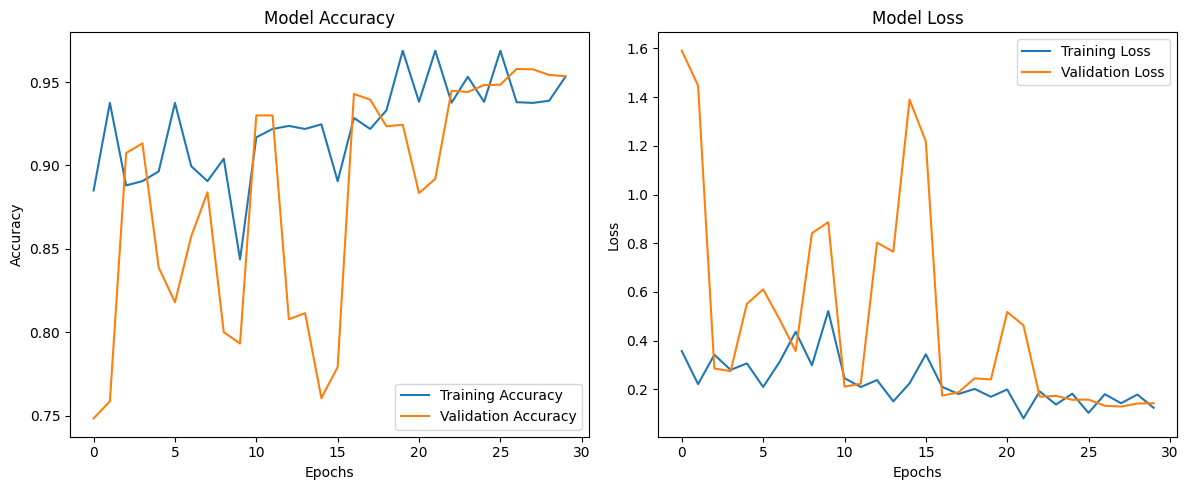

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained model
model = load_model('/content/model_CNN_GPU_.keras')  # Replace 'model.h5' with the path to your saved model

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Visualize training history
def plot_training_history(history):
    """
    Function to plot training and validation accuracy and loss.
    """
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Load training history from saved training process (optional)
# If you have a saved history object, load it
import pickle
try:
    with open('history.pkl', 'rb') as file:  # Replace with your history file path
        history = pickle.load(file)
    plot_training_history(history)
except FileNotFoundError:
    print("Training history file not found. Unable to plot training metrics.")

# Alternatively, if training history is stored in `history` from model.fit()
# Uncomment the following lines if training and history are done in the same session:
plot_training_history(history.history)

In [ ]:
import cv2
import numpy as np

# Resize the test data to match the model's input shape
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_val])

In [ ]:
X_test_resized = X_test_resized / 255.0  # Normalize pixel values

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/model_DN.keras')  # Replace 'model.h5' with your saved model file path

# Assuming you have the test data (X_test) and test labels (Y_test)
# Load test data if not already loaded (replace with your paths if applicable)
# X_test = np.load('X_test.npy')  # Test dataset
#Y_test = np.load('Y_test.npy')  # Test labels (one-hot encoded)

# Convert Y_test to class labels if one-hot encoded
Y_test_classes = np.argmax(Y_val, axis=1)  # Convert one-hot to class labels

# Make predictions using the loaded model
Y_pred_probs = model.predict(X_val, verbose=1)  # Predict probabilities
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)  # Convert probabilities to class labels

# Calculate Metrics
accuracy = accuracy_score(Y_test_classes, Y_pred_classes) * 100
precision = precision_score(Y_test_classes, Y_pred_classes, average='weighted')  # Weighted for imbalanced datasets
recall = recall_score(Y_test_classes, Y_pred_classes, average='weighted')
f1 = f1_score(Y_test_classes, Y_pred_classes, average='weighted')

# Print Metrics
print(f"Accuracy (%): {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Classification Report (Optional)
print("\nClassification Report:")
# Replace 'disease_types' with the list of class names (e.g., ['Class1', 'Class2', ...])
disease_types = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight',
                 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight',
                 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
                 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot',
                 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
print(classification_report(Y_test_classes, Y_pred_classes, target_names=disease_types))

129/129 ━━━━━━━━━━━━━━━━━━━━ 80s 564ms/step
Accuracy (%): 91.30
Precision: 0.92
Recall: 0.91
F1-Score: 0.91

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.93      0.95       199
                     Pepper__bell___healthy       0.97      1.00      0.98       296
                      Potato___Early_blight       0.80      1.00      0.89       213
                       Potato___Late_blight       0.95      0.93      0.94       205
                           Potato___healthy       0.39      1.00      0.56        28
                      Tomato_Bacterial_spot       0.95      0.94      0.95       399
                        Tomato_Early_blight       0.98      0.85      0.91       206
                         Tomato_Late_blight       0.93      0.93      0.93       379
                           Tomato_Leaf_Mold       0.98      0.87      0.92       187
                 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import cv2
import numpy as np

# Load the saved model
model = load_model('/content/plant_disease_model_EfficientNet1.h5')  # Replace with your saved model path

# Assuming you have the test data (X_val) and labels (Y_val)
# If test data has a different shape, resize it to match the model's input size
IMAGE_SIZE = (224,224)  # Update this to match the input shape of your model
X_val_resized = np.array([cv2.resize(img, IMAGE_SIZE) for img in X_val])  # Resize test data
X_val_resized = X_val_resized / 255.0  # Normalize pixel values to [0, 1]

# Convert Y_val to class labels if it is one-hot encoded
Y_test_classes = np.argmax(Y_val, axis=1)  # Convert one-hot to class labels

# Make predictions using the loaded model
Y_pred_probs = model.predict(X_val_resized, verbose=1)  # Predict probabilities
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)  # Convert probabilities to class labels

# Calculate Metrics
accuracy = accuracy_score(Y_test_classes, Y_pred_classes) * 100
precision = precision_score(Y_test_classes, Y_pred_classes, average='weighted')  # Weighted for imbalanced datasets
recall = recall_score(Y_test_classes, Y_pred_classes, average='weighted')
f1 = f1_score(Y_test_classes, Y_pred_classes, average='weighted')

# Print Metrics
print(f"Accuracy (%): {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Classification Report (Optional)
print("\nClassification Report:")
# Replace 'disease_types' with the list of class names
disease_types = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight',
                 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight',
                 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
                 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot',
                 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
print(classification_report(Y_test_classes, Y_pred_classes, target_names=disease_types))

129/129 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step
Accuracy (%): 9.18
Precision: 0.01
Recall: 0.09
F1-Score: 0.02

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.00      0.00       199
                     Pepper__bell___healthy       0.00      0.00      0.00       296
                      Potato___Early_blight       0.00      0.00      0.00       213
                       Potato___Late_blight       0.00      0.00      0.00       205
                           Potato___healthy       0.00      0.00      0.00        28
                      Tomato_Bacterial_spot       0.00      0.00      0.00       399
                        Tomato_Early_blight       0.00      0.00      0.00       206
                         Tomato_Late_blight       0.09      1.00      0.17       379
                           Tomato_Leaf_Mold       0.00      0.00      0.00       187
                  To

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
!pip install --upgrade tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
   

#VGG16

Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5301 - loss: 1.5259
Epoch 1: val_accuracy improved from -inf to 0.73765, saving model to vgg16_plantvillage.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5305 - loss: 1.5246 - val_accuracy: 0.7376 - val_loss: 0.8303 - learning_rate: 0.0010
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7236 - loss: 0.8723
Epoch 2: val_accuracy improved from 0.73765 to 0.78125, saving model to vgg16_plantvillage.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7236 - loss: 0.8723 - val_accuracy: 0.7812 - val_loss: 0.6820 - learning_rate: 0.0010
Epoch 3/30
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7567 - loss: 0.7654
Epoch 3: val_accuracy improved from 0.78125 to 0.80354, saving model to vgg16_plantvillage.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7567 - loss: 0.7654 - val_accuracy: 0.8035 - val_loss: 0.5986 - learning_rate: 0.0010
Epoch 4/30
258/258 ━━━━

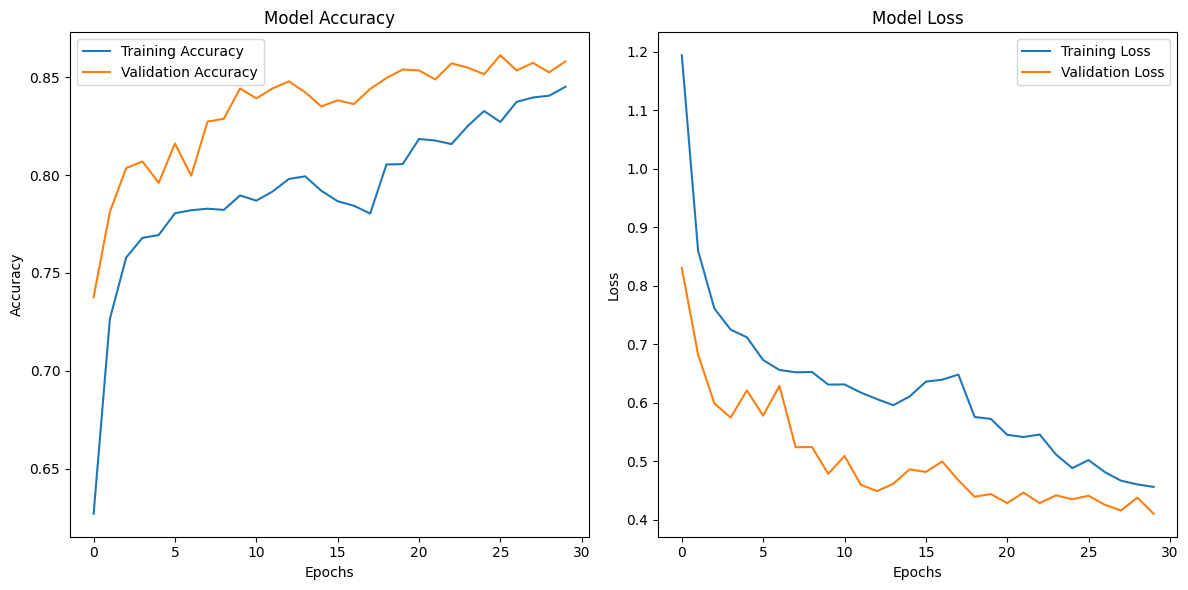

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Define the VGG16 model tailored for 64x64 images
def build_vgg16():
    # Load the VGG16 base model with input shape adjusted to 64x64
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False  # Freeze base model layers

    # Add custom layers
    inputs = Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    outputs = Dense(15, activation='softmax')(x)  # 15 classes from the dataset

    # Define the complete model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.summary()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the model
model = build_vgg16()

# Callbacks for training
checkpoint = ModelCheckpoint('vgg16_plantvillage_2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss * 100:.2f}%")

# Generate classification report
Y_pred_probs = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)
Y_true_classes = np.argmax(Y_val, axis=1)
print("\nClassification Report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=disease_types))

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 2, 2, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,553,807 (78.41 MB)

 Trainable params: 528,911 (2.02 MB)

 Non-trainable params: 20,024,896 (76.39 MB)

Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4967 - loss: 1.6256
Epoch 1: val_accuracy improved from -inf to 0.70252, saving model to vgg19_plantvillage.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.4970 - loss: 1.6243 - val_accuracy: 0.7025 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 2/30
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6918 - loss: 0.9732
Epoch 2: val_accuracy improved from 0.70252 to 0.76042, saving model to vgg19_plantvillage.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6918 - loss: 0.9731 - val_accuracy: 0.7604 - val_loss: 0.7769 - learning_rate: 0.0010
Epoch 3/30
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7074 - loss: 0.8916
Epoch 3: val_accuracy did not improve from 0.76042
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7074 - loss: 0.8916 - val_accuracy: 0.7539 - val_loss: 0.7873 - learning_rate: 0.0010
Epoch 4/30
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.72

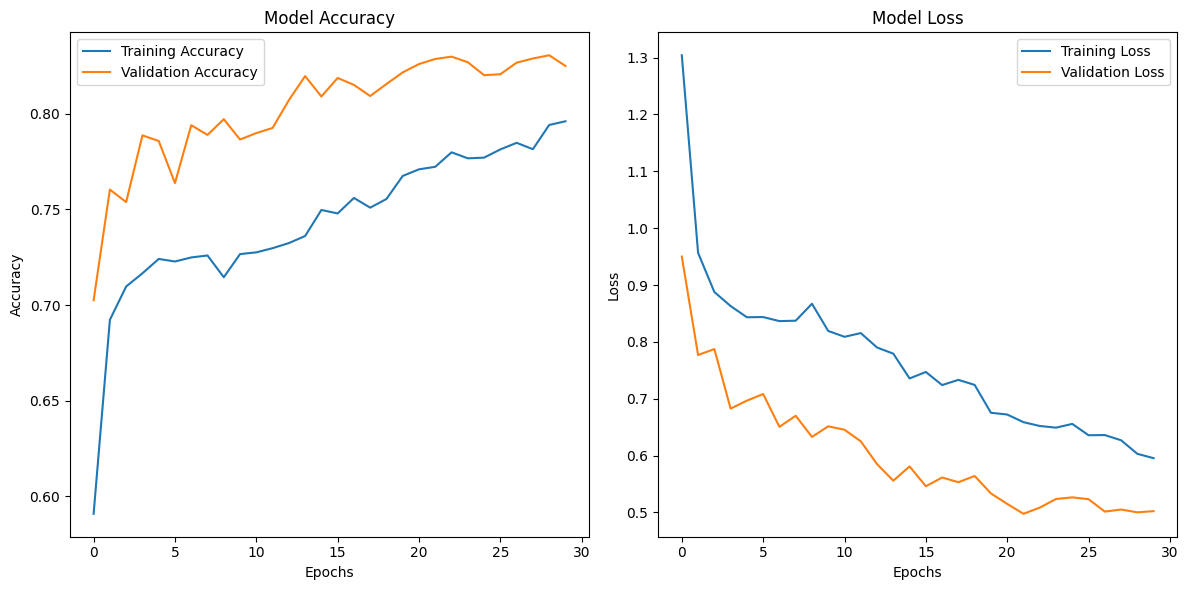

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the VGG19 model tailored for 64x64 images
def build_vgg19():
    # Load the VGG19 base model with input shape adjusted to 64x64
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False  # Freeze the base model layers

    # Add custom layers
    inputs = Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    outputs = Dense(15, activation='softmax')(x)  # 15 classes for the PlantVillage dataset

    # Define the complete model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.summary()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the model
vgg19_model = build_vgg19()

# Callbacks for training
checkpoint = ModelCheckpoint('vgg19_plantvillage.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# Train the model
history = vgg19_model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,  # Adjust epochs based on dataset size and performance
    batch_size=64,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

# Evaluate the model on the validation set
loss, accuracy = vgg19_model.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)